In [16]:
!pip install -U "transformers>=4.46.0" accelerate datasets scikit-learn
!pip install peft
!pip install hf_transfer
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2

In [2]:
import os
import random
import numpy as np
import pandas as pd
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model, TaskType

# Config

In [3]:
DATA_PATH = "train_absa.csv"
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
MAX_LENGTH = 512
RANDOM_SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(RANDOM_SEED)

# Load Data

In [4]:
df = pd.read_csv(DATA_PATH)
df = df.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)
df = df[df["sentiment"].isin(["positive", "negative"])].reset_index(drop=True)

print(df["sentiment"].value_counts())
labels = sorted(df["sentiment"].unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}
df["label"] = df["sentiment"].map(label2id)

train, val = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=RANDOM_SEED,
)

print("Train:", len(train), "Val:", len(val))

sentiment
positive    2131
negative    1472
Name: count, dtype: int64
Train: 3242 Val: 361


In [5]:
train_ds = Dataset.from_pandas(train[["id", "text", "aspect", "label"]])
val_ds   = Dataset.from_pandas(val[["id", "text", "aspect", "label"]])

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
})

train = train.reset_index(drop=True)
val   = val.reset_index(drop=True)

In [6]:
train["sentiment"].value_counts()

sentiment
positive    1917
negative    1325
Name: count, dtype: int64

# Tokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Qwen biasanya pakai eos sebagai pad, kita set eksplisit untuk aman
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Kalau mau, bisa pakai left padding untuk Qwen2ForSequenceClassification,
# tapi di sini right padding + max_length juga oke.
tokenizer.padding_side = "right"

POWER_PROMPT_TEMPLATE = """You are an expert in Aspect-Based Sentiment Analysis (ABSA).
Your task is to analyze a movie review and determine the sentiment towards a specific aspect.

Follow these strict rules:
1. Focus ONLY on the given aspect, not the whole review.
2. Use the tone and context of the review to infer sentiment.
3. Output MUST be exactly one of the following lowercase labels:
   - positive
   - negative

Review:
{review}

Aspect:
{aspect}

Question:
What is the sentiment towards the given aspect?

Answer with ONLY ONE WORD (positive, negative), no explanation:

Sentiment:"""

In [8]:
def preprocess(example):
    prompt = POWER_PROMPT_TEMPLATE.format(
        review=example["text"],
        aspect=example["aspect"],
    )

    encoded = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )
    encoded["labels"] = int(example["label"])
    return encoded

encoded_ds = dataset.map(
    preprocess,
    batched=False,
    remove_columns=["id", "text", "aspect", "__index_level_0__"],
)

Map:   0%|          | 0/3242 [00:00<?, ? examples/s]

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

# Model

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

# Samakan pad_token_id di config
model.config.pad_token_id = tokenizer.pad_token_id

# --- Konfigurasi LoRA (parameter-efficient fine-tuning) ---
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,   # sequence classification
    r=8,                          # rank LoRA (naikkan kalau punya GPU besar, mis: 16/32)
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # cek berapa % parameter yang di-train

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 4,400,896 || all params: 498,435,456 || trainable%: 0.8829


In [10]:
args = TrainingArguments(
    output_dir="qwen2.5_absa_lora",
    overwrite_output_dir=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,

    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    num_train_epochs=5,

    # 0.5B + LoRA cukup ringan; kalau masih OOM, turunkan batch_size atau MAX_LENGTH
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,

    # Untuk LoRA biasanya LR bisa sedikit lebih besar dari full FT
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_ratio=0.1,

    fp16=True,
    gradient_checkpointing=True,
    report_to="none",
)

In [11]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels_np = p.label_ids
    return {
        "accuracy": accuracy_score(labels_np, preds),
        "f1_macro": f1_score(labels_np, preds, average="macro"),
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipykernel_573/845306756.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.634000,0.602771,0.822715,0.817504
2,0.564800,0.528856,0.842105,0.837922
3,0.468700,0.491231,0.847645,0.843889
4,0.625700,0.478307,0.839335,0.834613
5,0.555000,0.484482,0.842105,0.837620


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=4055, training_loss=0.6422306043152156, metrics={'train_runtime': 390.5666, 'train_samples_per_second': 41.504, 'train_steps_per_second': 10.382, 'total_flos': 1.8041536413696e+16, 'train_loss': 0.6422306043152156, 'epoch': 5.0})

# Eval

In [12]:
val_metrics = trainer.evaluate(encoded_ds["validation"])
for k, v in val_metrics.items():
    try:
        print(f"{k}: {v:.4f}")
    except TypeError:
        print(k, ":", v)

eval_loss: 0.4912
eval_accuracy: 0.8476
eval_f1_macro: 0.8439
eval_runtime: 5.3553
eval_samples_per_second: 67.4100
eval_steps_per_second: 8.5900
epoch: 5.0000


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import textwrap


def plot_confusion_matrix(trainer, eval_dataset, id2label):
    preds_output = trainer.predict(eval_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels_np = preds_output.label_ids

    cm = confusion_matrix(labels_np, preds)
    label_names = [id2label[i] for i in range(len(id2label))]

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")  # gunakan colormap default
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=45, ha="right")
    plt.yticks(tick_marks, label_names)

    # Tulis angka di tiap kotak
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


def show_classification_report(trainer, eval_dataset, id2label):
    preds_output = trainer.predict(eval_dataset)

    preds = np.argmax(preds_output.predictions, axis=1)
    labels_np = preds_output.label_ids

    target_names = [id2label[i] for i in range(len(id2label))]

    print("\n=== Classification Report ===")
    print(classification_report(labels_np, preds, target_names=target_names, digits=4))

from collections import Counter

def show_label_distributions(trainer, eval_dataset, id2label):
    preds_output = trainer.predict(eval_dataset)

    preds = np.argmax(preds_output.predictions, axis=1)
    labels_np = preds_output.label_ids

    true_counts = Counter(labels_np)
    pred_counts = Counter(preds)

    print("\n=== Label Distribution (True vs Pred) ===")
    print("index -> label_name | true_count | pred_count")
    for i in range(len(id2label)):
        label_name = id2label[i]
        t = true_counts.get(i, 0)
        p = pred_counts.get(i, 0)
        print(f"{i} -> {label_name:>10} | true={t:4d} | pred={p:4d}")

def show_error_examples(trainer, eval_dataset, val_df, id2label, max_examples=10):
    preds_output = trainer.predict(eval_dataset)

    preds = np.argmax(preds_output.predictions, axis=1)
    labels_np = preds_output.label_ids

    wrong_idx = np.where(preds != labels_np)[0]

    print(f"\n=== Error Analysis ===")
    print(f"Total validation samples : {len(labels_np)}")
    print(f"Total misclassified      : {len(wrong_idx)} "
          f"({len(wrong_idx)/len(labels_np):.2%})")
    print(f"Showing up to {max_examples} examples:\n")

    for idx in wrong_idx[:max_examples]:
        row = val_df.iloc[idx]
        true_label = id2label[int(labels_np[idx])]
        pred_label = id2label[int(preds[idx])]
        print("-" * 80)
        print(f"ID      : {row['id']}")
        print(f"ASPECT  : {row['aspect']}")
        print(f"TRUE    : {true_label}")
        print(f"PRED    : {pred_label}")
        print("TEXT    :")
        print(row["text"])
        print()


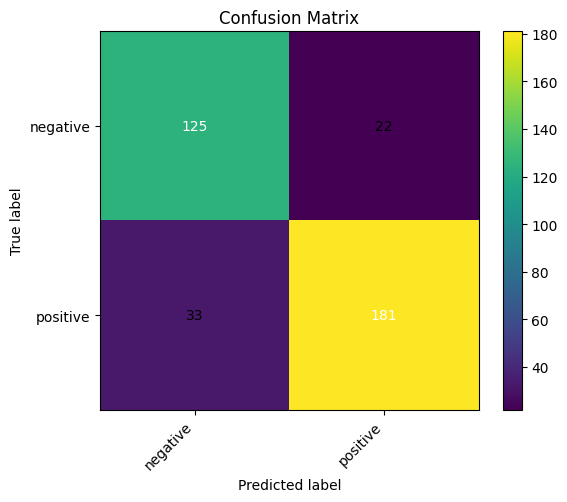

In [18]:
plot_confusion_matrix(trainer, encoded_ds["validation"], id2label)

In [19]:
show_classification_report(trainer, encoded_ds["validation"], id2label)


=== Classification Report ===
              precision    recall  f1-score   support

    negative     0.7911    0.8503    0.8197       147
    positive     0.8916    0.8458    0.8681       214

    accuracy                         0.8476       361
   macro avg     0.8414    0.8481    0.8439       361
weighted avg     0.8507    0.8476    0.8484       361



In [20]:
show_label_distributions(trainer, encoded_ds["validation"], id2label)


=== Label Distribution (True vs Pred) ===
index -> label_name | true_count | pred_count
0 ->   negative | true= 147 | pred= 158
1 ->   positive | true= 214 | pred= 203


In [21]:
show_error_examples(trainer, encoded_ds["validation"], val, id2label, max_examples=10)


=== Error Analysis ===
Total validation samples : 361
Total misclassified      : 55 (15.24%)
Showing up to 10 examples:

--------------------------------------------------------------------------------
ID      : pos_161
ASPECT  : plot
TRUE    : positive
PRED    : negative
TEXT    :
This silly movie is really fun for the younger audiences. Its heros are a couple of dud detectives whose sophomoric attitudes lead them down some very silly roads. Chasing the big murder case, you will see these detectives go to every length to solve the crime. No nudity, but lots of sexual implication, slapstick silliness...everything adolescents go for. Low budget, but very entertaining. Definite cult classic potential.

--------------------------------------------------------------------------------
ID      : neg_327
ASPECT  : script
TRUE    : negative
PRED    : positive
TEXT    :
Even if you're a huge Sandler fan, please don't bother with this extremely disappointing comedy! I bought this movie for $7.9

In [14]:
save_path = "qwen2.5_absa_saved"
trainer.model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("Model disimpan di:", save_path)

# zip_path = "/content/qwen2.5_absa_saved.zip"
# shutil.make_archive("/content/qwen2.5_absa_saved", "zip", save_path)
# files.download(zip_path)

Model disimpan di: qwen2.5_absa_saved
